## IMPORTING LIBRARIES


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd
import math
import datetime
import platform
import cv2
print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)
import os
import h5py
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline
import tensorflow.keras.backend as K
# Image dataset has channels as its last dimensions
K.set_image_data_format('channels_last')

Python version: 3.10.12
Tensorflow version: 2.12.0
Keras version: 2.12.0
Python version: 3.10.12
Tensorflow version: 2.12.0
Keras version: 2.12.0


In [11]:
# Load the TensorBoard notebook extension.
# %reload_ext tensorboard
%load_ext tensorboard

# Clear any logs from previous runs.
!rm -rf ./.logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


##Data Preprocessing

In [12]:
mnist_dataset = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()

print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

# Save image parameters to the constants that we will use later for data re-shaping and for model traning.
(Number_of_elements, IMAGE_WIDTH, IMAGE_HEIGHT) = x_train.shape
IMAGE_CHANNELS = 1

print('Number_of_elements:', Number_of_elements)
print('IMAGE_WIDTH:', IMAGE_WIDTH)
print('IMAGE_HEIGHT:', IMAGE_HEIGHT)
print('IMAGE_CHANNELS:', IMAGE_CHANNELS)

11490434/11490434 [==============================] - 1s 0us/step
x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)
Number_of_elements: 60000
IMAGE_WIDTH: 28
IMAGE_HEIGHT: 28
IMAGE_CHANNELS: 1
x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)
Number_of_elements: 60000
IMAGE_WIDTH: 28
IMAGE_HEIGHT: 28
IMAGE_CHANNELS: 1


In [13]:
print('Initial x_train : ', x_train.shape) # (60000, 28, 28)
x_train = np.expand_dims(x_train, axis=-1)
x_train = tf.image.resize(x_train, [32,32])
print('Final x_train : ', x_train.shape) # (60000, 32, 32, 1)


print('Initial x_test : ', x_test.shape) # (60000, 28, 28)
x_test = np.expand_dims(x_test, axis=-1)
x_test = tf.image.resize(x_test, [32,32])
print('Final x_test : ' ,x_test.shape) # (60000, 32, 32, 1)

Initial x_train :  (60000, 28, 28)
Final x_train :  (60000, 32, 32, 1)
Initial x_test :  (10000, 28, 28)
Final x_test :  (10000, 32, 32, 1)
Initial x_train :  (60000, 28, 28)
Final x_train :  (60000, 32, 32, 1)
Initial x_test :  (10000, 28, 28)
Final x_test :  (10000, 32, 32, 1)


In [14]:
x_train_normalized = x_train / 255
x_test_normalized = x_test / 255
#x_train_normalized = np.repeat(x_train, 3, axis=3)
#x_test_normalized = np.repeat(x_test, 3, axis=3)

In [15]:
# print(x_train_normalized.shape)
# print(x_test_normalized.shape)

## MODEL ARCHITECHTURE & training:

In [16]:
import tensorflow as tf
class Involution(keras.layers.Layer):
    def __init__(
        self, channel, group_number, kernel_size, stride, reduction_ratio, name=None):
        super().__init__(name=name)

        # Initialize the parameters.
        self.channel = channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio

    def get_config(self):
     #   config = super().get_config()
        config=({
                  'channel': self.channel,
                  'group_number': self.group_number,
                  'reduction_ratio': self.reduction_ratio,
                  'kernel_size': self.kernel_size,
                  'stride': self.stride
                  })
        return config


    def build(self, input_shape):
        # Get the shape of the input.
        (_, height, width, num_channels) = input_shape

        # Scale the height and width with respect to the strides.
        height = height // self.stride
        width = width // self.stride

        # Define a layer that average pools the input tensor
        # if stride is more than 1.
        self.stride_layer = (
            keras.layers.AveragePooling2D(
                pool_size=self.stride, strides=self.stride, padding="same"
            )
            if self.stride > 1
            else tf.identity
        )
        # Define the kernel generation layer.
        self.kernel_gen = keras.Sequential(
            [
                keras.layers.Conv2D(
                    filters=self.channel // self.reduction_ratio, kernel_size=1
                ),
                keras.layers.BatchNormalization(),
                keras.layers.ReLU(),
                keras.layers.Conv2D(
                    filters=self.kernel_size * self.kernel_size * self.group_number,
                    kernel_size=1,
                ),
            ]
        )
        # Define reshape layers
        self.kernel_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                1,
                self.group_number,
            )
        )
        self.input_patches_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                num_channels // self.group_number,
                self.group_number,
            )
        )
        self.output_reshape = keras.layers.Reshape(
            target_shape=(height, width, num_channels)
        )

    def call(self, x):
        # Generate the kernel with respect to the input tensor.
        # B, H, W, K*K*G
        kernel_input = self.stride_layer(x)
        kernel = self.kernel_gen(kernel_input)

        # reshape the kerenl
        # B, H, W, K*K, 1, G
        kernel = self.kernel_reshape(kernel)

        # Extract input patches.
        # B, H, W, K*K*C
        input_patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.kernel_size, self.kernel_size, 1],
            strides=[1, self.stride, self.stride, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )

        # Reshape the input patches to align with later operations.
        # B, H, W, K*K, C//G, G
        input_patches = self.input_patches_reshape(input_patches)

        # Compute the multiply-add operation of kernels and patches.
        # B, H, W, K*K, C//G, G
        output = tf.multiply(kernel, input_patches)
        # B, H, W, C//G, G
        output = tf.reduce_sum(output, axis=3)

        # Reshape the output kernel.
        # B, H, W, C
        output = self.output_reshape(output)

        # Return the output tensor and the kernel.
        return output

In [ ]:
def identity_block(X, f, filters, stage, block):

    inv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
    #X=Involution(channel=F1,group_number=1,kernel_size=1,stride=1,reduction_ratio=1, name="inv_01_"+bn_name_base + '2a')(X)
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name="conv1" + bn_name_base+ '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X=Involution(channel=F2,group_number=1,kernel_size=f,stride=1,reduction_ratio=1, name="inv_02_"+bn_name_base + '2b')(X)
    #X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=inv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    #X=Involution(channel=F3,group_number=1,kernel_size=1,stride=1,reduction_ratio=1, name="inv_03_"+bn_name_base + '2c')(X)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name="conv3" + bn_name_base +'2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):

    inv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters
    #X_shortcut = X
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='same', name="conv1" + bn_name_base+ '2a'+"shortcut", kernel_initializer=glorot_uniform(seed=0))(X)
    #X=Involution(channel=F1,group_number=1,kernel_size=1,stride=s,reduction_ratio=1, name="inv_1_"+bn_name_base + '2a')(X)
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name="conv1" + bn_name_base+ '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X=Involution(channel=F2,group_number=1,kernel_size=f,stride=1,reduction_ratio=1, name="inv_2_"+bn_name_base + '2b')(X)
    print(1)
    print(X.shape, X_shortcut.shape)
    #X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    #X=Involution(channel=F3,group_number=1,kernel_size=1,stride=1,reduction_ratio=1, name="inv_3_"+bn_name_base + '2c')(X)
    print(2)
    print(X.shape, X_shortcut.shape)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name="conv3" + bn_name_base +'2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut=Involution(channel=F3,group_number=1,kernel_size=1,stride=s,reduction_ratio=1,  name="inv_4_"+bn_name_base + '2d')(X_shortcut)

    #X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)
    print(3)
    print(X.shape, X_shortcut.shape)
    X = Add()([X, X_shortcut])
    print(4)
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape=(32, 32, 1), classes = 10, n=16):

    X_input = Input(input_shape)

    #X = ZeroPadding2D((3, 3))(X_input)
    #X = Conv2D(64, (7, 7), strides=(1, 1), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X_input)
    X=Involution(channel=64//n,group_number=1,kernel_size=7,stride=2,reduction_ratio=1, name="inv_0")(X_input)

    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64//n, 64//n, 256//n], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64//n, 64//n, 256//n], stage=2, block='b')
    X = identity_block(X, 3, [64//n, 64//n, 256//n], stage=2, block='c')



    X = convolutional_block(X, f=3, filters=[128//n, 128//n, 512//n], stage=3, block='a', s=2)

    X = identity_block(X, 3, [128//n, 128//n, 512//n], stage=3, block='b')
    X = identity_block(X, 3, [128//n, 128//n, 512//n], stage=3, block='c')
    X = identity_block(X, 3, [128//n, 128//n, 512//n], stage=3, block='d')


    X = convolutional_block(X, f=3, filters=[256//n, 256//n, 1024//n], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256//n, 256//n, 1024//n], stage=4, block='b')
    X = identity_block(X, 3, [256//n, 256//n, 1024//n], stage=4, block='c')
    X = identity_block(X, 3, [256//n, 256//n, 1024//n], stage=4, block='d')
    X = identity_block(X, 3, [256//n, 256//n, 1024//n], stage=4, block='e')
    X = identity_block(X, 3, [256//n, 256//n, 1024//n], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512//n, 512//n, 2048//n], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512//n, 512//n, 2048//n], stage=5, block='b')
    X = identity_block(X, 3, [512//n, 512//n, 2048//n], stage=5, block='c')

    X = AveragePooling2D(pool_size=(1, 1), padding='same')(X)



    # output layer
    X = Flatten()(X)
    X = Dense(256, activation='relu', name='fc_d1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')
    return model

In [ ]:
model = ResNet50()
model.summary()

1
(None, 8, 8, 4) (None, 8, 8, 16)
2
(None, 8, 8, 4) (None, 8, 8, 16)
3
(None, 8, 8, 16) (None, 8, 8, 16)
4
1
(None, 8, 8, 8) (None, 8, 8, 32)
2
(None, 8, 8, 8) (None, 8, 8, 32)
3
(None, 4, 4, 32) (None, 4, 4, 32)
4
1
(None, 4, 4, 16) (None, 4, 4, 64)
2
(None, 4, 4, 16) (None, 4, 4, 64)
3
(None, 2, 2, 64) (None, 2, 2, 64)
4
1
(None, 2, 2, 32) (None, 2, 2, 128)
2
(None, 2, 2, 32) (None, 2, 2, 128)
3
(None, 1, 1, 128) (None, 1, 1, 128)
4
Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 inv_0 (Involution)             (None, 16, 16, 1)    269         ['input_2[0][0]']                
                                               

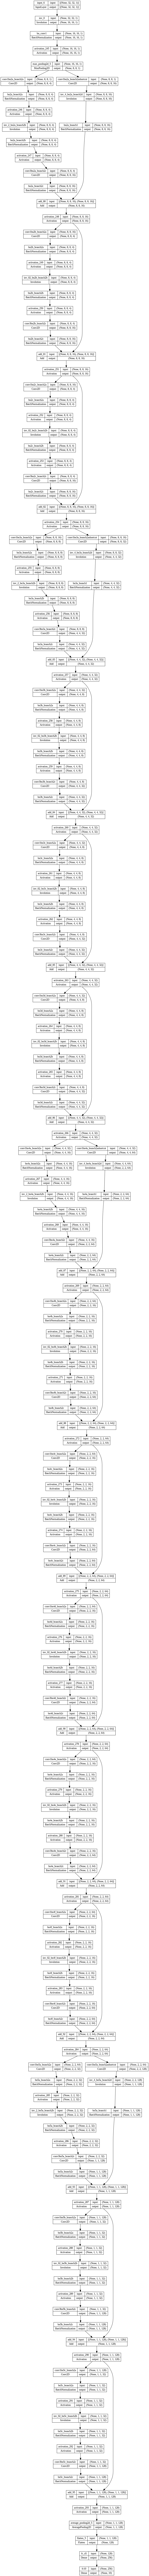

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:


# set the path to the folder where you want to save the image
save_path = '/content/MNIST'

# assuming your image is saved as 'my_image.png' in Colab
image_name = 'model.png'

# save the image to Google Drive
!cp {image_name} {save_path}


### COMPILE & TRAIN MODEL

In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [ ]:
trining_history = model.fit(x_train_normalized,
     y_train,
     epochs=100,
     batch_size = 256,
     validation_data=(x_test_normalized, y_test),
 )

Epoch 1/50
235/235 [==============================] - 84s 104ms/step - loss: 2.3200 - accuracy: 0.1192 - val_loss: 2.3048 - val_accuracy: 0.1135
Epoch 2/50
235/235 [==============================] - 21s 88ms/step - loss: 2.2659 - accuracy: 0.1534 - val_loss: 2.3217 - val_accuracy: 0.1135
Epoch 3/50
235/235 [==============================] - 21s 90ms/step - loss: 2.1546 - accuracy: 0.2172 - val_loss: nan - val_accuracy: 0.1430
Epoch 4/50
235/235 [==============================] - 21s 91ms/step - loss: 2.0044 - accuracy: 0.2770 - val_loss: nan - val_accuracy: 0.1924
Epoch 5/50
235/235 [==============================] - 20s 85ms/step - loss: 1.7779 - accuracy: 0.3703 - val_loss: 2.3829 - val_accuracy: 0.2509
Epoch 6/50
235/235 [==============================] - 21s 89ms/step - loss: 1.3843 - accuracy: 0.5315 - val_loss: nan - val_accuracy: 0.3288
Epoch 7/50
235/235 [==============================] - 21s 89ms/step - loss: 0.9778 - accuracy: 0.6798 - val_loss: nan - val_accuracy: 0.6428
Epo

# Model evaluation

In [ ]:
train_loss, train_accuracy = model.evaluate(x_train_normalized, y_train)
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)

In [ ]:
validation_loss, validation_accuracy = model.evaluate(x_test_normalized, y_test)
print('Validation loss: ', validation_loss)
print('Validation accuracy: ', validation_accuracy)

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Model Reload

In [18]:
from tensorflow.keras.models import model_from_json


with open('/content/drive/MyDrive/JU ETCE Research under SSC mam/MNIST/invo resnet/model_architecture.json', 'r') as json_file:
    loaded_model_json = json_file.read()
from tensorflow.keras.utils import custom_object_scope
with custom_object_scope({'Involution': Involution}):

    model = model_from_json(loaded_model_json)

model.load_weights('/content/drive/MyDrive/JU ETCE Research under SSC mam/MNIST/invo resnet/model_weights.h5')
optimizer=tf.keras.optimizers.legacy.Adam()
model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])

In [ ]:
select_layers = [layer for layer in model.layers if layer.name[:4] == 'acti' or layer.name[:3] == 'inp']
select_layers=select_layers[::2]
len(select_layers)

25

0
1/1 [==============================] - 0s 105ms/step
1
1/1 [==============================] - 7s 7s/step
2
1/1 [==============================] - 0s 417ms/step
3
1/1 [==============================] - 0s 381ms/step
4


1/1 [==============================] - 0s 393ms/step
5


1/1 [==============================] - 0s 461ms/step
6
1/1 [==============================] - 1s 606ms/step
7
1/1 [==============================] - 1s 766ms/step
8
1/1 [==============================] - 1s 790ms/step
9
1/1 [==============================] - 1s 815ms/step
10
1/1 [==============================] - 1s 826ms/step
11
1/1 [==============================] - 1s 926ms/step
12
1/1 [==============================] - 1s 1s/step
13
1/1 [==============================] - 2s 2s/step
14
1/1 [==============================] - 2s 2s/step
15
1/1 [==============================] - 1s 1s/step
16
1/1 [==============================] - 1s 1s/step
17
1/1 [==============================] - 1s 1s/step
18
1/1 [==============================] - 1s 1s/step
19
1/1 [==============================] - 1s 1s/step
20
1/1 [==============================] - 2s 2s/step
21
1/1 [==============================] - 2s 2s/step
22
1/1 [==============================] - 3s 3s/step
23
1/1 [========================

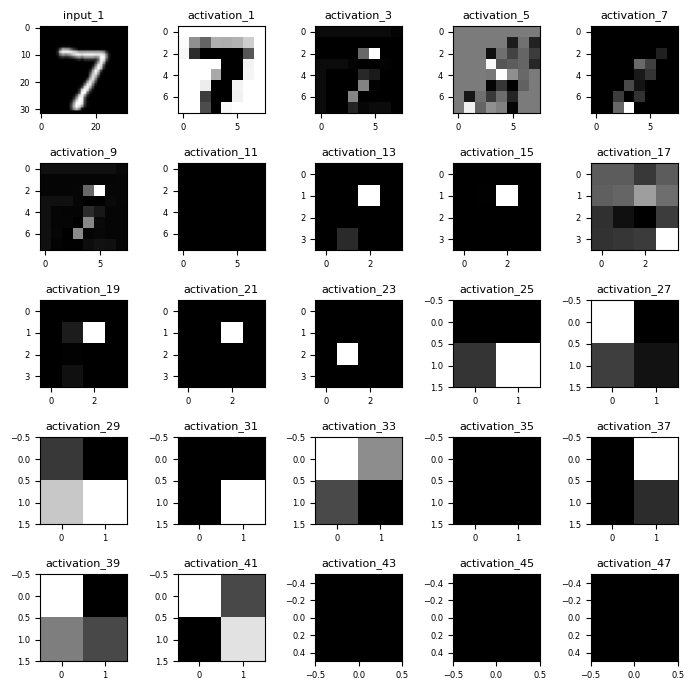

In [ ]:
image=x_test_normalized[0]
grid_size = 5
fig, axs = plt.subplots(grid_size, grid_size, figsize=(7, 7))
for i,layer in enumerate(select_layers):
    print(i)
    intermediate_model = tf.keras.Model(inputs=model.input, outputs=layer.output)
    intermediate_output = intermediate_model.predict(image[np.newaxis, ...])
    row = i // grid_size
    col = i % grid_size
    ax = axs[row, col]
    ax.imshow(intermediate_output[0, :, :, 0],cmap='gray')
    ax.set_title(layer.name,fontsize=8)
    ax.tick_params(axis='both', which='both', labelsize=6)
plt.subplots_adjust(hspace=0.5)
plt.savefig('invo_grid_mnist')
plt.tight_layout()
plt.show()


In [ ]:
loss, accuracy = model.evaluate(x_test_normalized, y_test)

313/313 [==============================] - 9s 13ms/step - loss: nan - accuracy: 0.8826


In [19]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

In [30]:
model = tf.keras.models.load_model('/content/drive/MyDrive/JU ETCE Research under SSC mam/MNIST/resnet 50/best model.h5')

313/313 [==============================] - 48s 148ms/step
Confusion Matrix:
[[ 979    0    0    0    0    0    0    0    1    0]
 [   1 1122    3    0    1    0    0    1    7    0]
 [   4    0 1023    0    0    0    1    0    4    0]
 [   3    0    2  993    0    6    0    3    3    0]
 [   0    0    0    0  972    0    1    1    3    5]
 [   4    0    0    6    1  875    1    1    2    2]
 [  16    2    0    0    3    1  934    0    2    0]
 [   1    2    4    0    3    0    0 1013    3    2]
 [   8    0    4    0    1    2    0    2  956    1]
 [   4    1    0    3    6    5    0   11    9  970]]


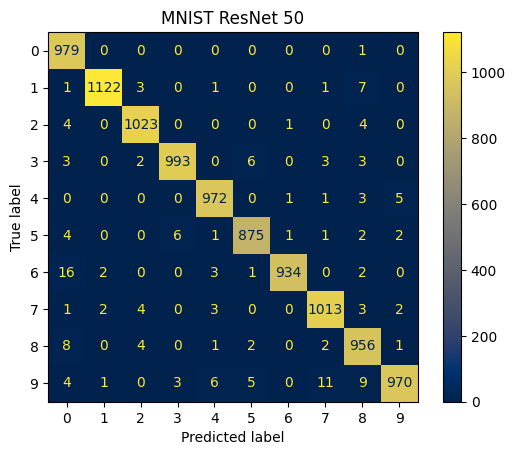

In [31]:
y_pred = model.predict(x_test_normalized)
y_pred_classes = np.argmax(y_pred, axis=1)
#y_true_classes = np.argmax(y_test, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='cividis')
plt.title("MNIST ResNet 50")
plt.savefig('/content/drive/MyDrive/JU ETCE Research under SSC mam/MNIST/resnet 50/mnist_resnet50_cm.png')
plt.show()

# Plot confusion matrix



In [32]:
from sklearn.metrics import precision_score, f1_score, recall_score
precision = precision_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

Precision: 0.9838839415323504
F1 Score: 0.9837101393003279
Recall: 0.9837


# decision tree

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape and flatten the input data
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

# Create a decision tree classifier
classifier = DecisionTreeClassifier()

# Train the classifier
classifier.fit(x_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(x_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8793


Confusion Matrix:
[[ 919    0    7    8    5    9   11    4    9    8]
 [   3 1085    9    6    0    3    9    3   14    3]
 [  13   10  896   25    9    8   12   25   23   11]
 [   8    6   29  851    7   40    7   10   28   24]
 [   3    2   10    6  861   13   15   11   19   42]
 [  13    6    6   47   10  741   23    8   20   18]
 [  16    5   13    8   18   19  844    1   28    6]
 [   2   11   25   21    7    4    2  923    7   26]
 [  12    7   32   35   18   32   13    7  791   27]
 [  14    5    9   19   38   13    5   20   25  861]]


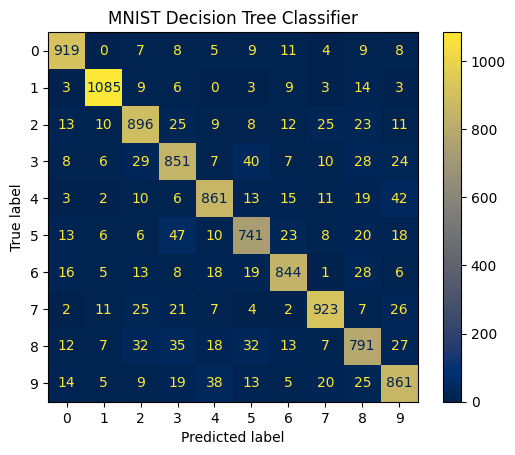

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='cividis')
plt.title("MNIST Decision Tree Classifier")
plt.savefig('/content/drive/MyDrive/JU ETCE Research under SSC mam/MNIST/invo resnet/mnist_dtc_cm (1).png')
plt.show()

In [29]:
from sklearn.metrics import precision_score, f1_score, recall_score
precision = precision_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

Precision: 0.9838839415323504
F1 Score: 0.9837101393003279
Recall: 0.9837
